# Figure 1

**Figure 1 | Task, behavior, and electrode locations.** (A) Task design. A fixation period of 250-500 ms is followed by the presentation of 3-5 piano tones (C4 - B4). The first 2-4 tones are presented isochronously with inter-onset intervals ranging from 333-1000 ms (1-3 Hz). The last tone in the sequence is jittered relative to the inter-onset interval (IOI). Trial-wise jitters were randomly drawn from a uniform distribution ranging ±40% of the IOI. After 210 ms, the participant is cued to respond if the tone is early or late, and how confident they are in their response on a scale of 1-4, where a confident early response is indicated by a keypress of 1 and a confident late response is indicated by keypress of 4. A less confident response is a forced choice between 2 and 3. (B) Average sigmoid fits of behavioral accuracy in healthy participants performing the task, by condition (blue: 3 tones, orange: 4 tones, green: 5 tones). Average fit is a solid line and shading represents one standard deviation. Equivalence point (𝜇) of sigmoid fits did not differ between conditions (one-way rm-ANOVA), but slope (𝜎) significantly increased on trials with more than three tones (one-way rm-ANOVA: p = 2.30x10-5). (𝜎3-tone = 9.56±4.23, 𝜎4-tone = 16.90±7.46; Holm-Bonferroni corrected two-tailed paired t-test: p = 6.50x10-4, n = 11); (𝜎3-tone = 9.56±4.23, 𝜎5-tone = 22.23±8.71; Holm-Bonferroni-corrected two-tailed paired t-test: p = 6.09x10-4, n = 11). (C) Average sigmoid fits of behavioral accuracy in sEEG participants performing the task. Color, line style, and shading like panel B. 𝜇 did not differ between conditions (one-way rm-ANOVA). 𝜎 significantly increased on trials with more than three tones (one-way rm-ANOVA: p = 1.63x10-3). (𝜎3-tone = 7.13±6.08, 𝜎4-tone = 11.39±7.84; Holm-Bonferroni corrected two-tailed paired t-test: p = 9.26x10-3, n = 7); (𝜎3-tone = 7.13±6.08, 𝜎5-tone = 11.63±8.43; Holm-Bonferroni corrected, two-tailed paired t-test: p = 0.04, n = 7). Neither 𝜎 nor 𝜇 were significantly different between healthy participants and sEEG participants (one-way mixed ANOVA). (D) Cortical locations of midpoints between bipolar contact pairs in seven sEEG participants, where electrodes were implanted based solely on clinical needs.



### imports

In [1]:
%matplotlib inline
import os
import os.path as op
import pandas as pd
import numpy as np
from glob import glob
import pingouin as pg

from scipy.stats import norm, binned_statistic
from scipy.optimize import fmin

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sns.set_context('talk')

### analysis functions

In [3]:
def load_behav(resdir):
    # creating a search term to grab all the csv files in the folder
    subsearch = op.join(resdir, '*exp.csv')
    
    # making an array of those filenames
    subfiles = np.sort(np.array(glob(subsearch)))
    
    # pulling out participant ids
    sub_ids = [a[a.find('/', -15, -1)+1:a.find('_exp.csv')] for a in subfiles]
    
    # opening each csv file and manipulating it
    subData = list()
    for file in subfiles:
        data = pd.read_csv(file, skipinitialspace=True);
        # remove the training blocks
        data = data[data['Block #'] != 0]
        data.sub_id = file[file.find('/')+1:file.find('_exp.csv')]
        subData.append(data)

    return subData, sub_ids

# sigmoid function
def simpsych(x, pars):
    return  1./(1 + np.e**((pars[0]-x)*pars[1])) # pars[0] = u (the equivalence point), pars[1] = sigma (the slope); x = jitter

# cost function for fitting
cost = lambda pars, r, j : -np.mean(r*np.log(simpsych(j, pars))
             + (1 - r)*np.log(1 - simpsych(j, pars)))

def compute_sigmoid_fit_params(subData, cost):

    all_pars = list()
    for data in subData:
        jitter = (data['SOA Jitter'] - data['SOA'])/1000.
        rating = (data['Rating'] - np.min(data['Rating']))/np.ptp(data['Rating'])
        sub_pars = list()
        for tonenum in np.unique(data['Standard #']):
            
            # get ratings and jitters for specific tone numbers
            indx = data['Standard #'] == tonenum
            rat = rating[indx]
            jit = jitter[indx]
            
            # fit the data                                                      
            params = fmin(cost, np.array([0, 1]), (rat, jit), disp=False)
            x = np.linspace(-np.max(np.abs(jit)), np.max(np.abs(jit)), 241)
            sub_pars.append(params) 
            
        all_pars.append(sub_pars)
    
    all_pars = np.array(all_pars)

    return all_pars

### plotting functions


In [7]:
def plot_sigmoid_params(all_pars, sub_ids):
    rows, cols = 1, 2
    fig, axs = plt.subplots(rows, cols, figsize=(6,3.5))
    parnames= ['Equivalence', 'Sigmoid Slope']
    data = subData[0]
    for ind, par in enumerate(all_pars):
        for n in range(2):
            axs[n].plot(np.unique(data['Standard #']+1), par[:, n], 
                        ms=20, color='k', alpha=0.05, label=sub_ids[ind], zorder=0, lw=4)
            axs[n].set_xticks(np.unique(data['Standard #']+1))
            axs[n].set_ylabel(parnames[n], fontsize=16)
            axs[n].set_xlabel('# of tones', fontsize=16)

    x_jitter = (np.random.normal(0, 0.02, size=len(sub_ids)))

    for y_ind, x_ind in enumerate([3,4,5]):
        # subject values
        axs[0].scatter(np.tile(x_ind, len(sub_ids))+x_jitter, all_pars[:,y_ind,0], alpha=0.7)
        axs[1].scatter(np.tile(x_ind, len(sub_ids))+x_jitter, all_pars[:,y_ind,1], alpha=0.7)

        # average values
        axs[0].plot([x_ind-0.15, x_ind+0.15], [np.mean(all_pars[:,y_ind,0]), np.mean(all_pars[:,y_ind,0])], lw=6)
        axs[1].plot([x_ind-0.15, x_ind+0.15], [np.mean(all_pars[:,y_ind,1]), np.mean(all_pars[:,y_ind,1])], lw=6)


    axs[0].set_ylim([-0.2, 0.2])
    axs[1].set_ylim([0,45])
    axs[0].set_xlim(2.75, 5.25)
    axs[1].set_xlim(2.75, 5.25)
    sns.despine()
    fig.tight_layout()

def plot_sigmoid_fits(all_pars, group):
    """group is 'HC' or 'sEEG' """
    
    # compute errors
    x = np.linspace(-0.4, 0.4, 214)
    errors = []
    # for each condition
    for c in range(0,all_pars.shape[1]):
        ys = []
        for s in range(0,all_pars.shape[0]):
            # calculate 10 sigmoid fits
            y = simpsych(x, all_pars[s][c])
            ys.append(y)
        ys = np.asarray(ys)
        # calculate std of 10 sigmoid fits
        error = ys.std(axis=0)
        # return error array for each condition
        errors.append(error)

        plt.figure(figsize=[6,4])

    y2 = simpsych(x, all_pars.mean(axis=0)[0])
    y3 = simpsych(x, all_pars.mean(axis=0)[1])
    y4 = simpsych(x, all_pars.mean(axis=0)[2])
    
    plt.plot(x, y2, label='3 ♪')
    plt.plot(x, y3, label='4 ♪')
    plt.plot(x, y4, label='5 ♪')
    
    plt.fill_between(x, y2-errors[0], y2+errors[0], alpha=0.2)
    plt.fill_between(x, y3-errors[1], y3+errors[1], alpha=0.2)
    plt.fill_between(x, y4-errors[2], y4+errors[2], alpha=0.2)
    
    plt.ylim(-0.1, 1.1)
    
    plt.legend()
    plt.axvline(0, color='k', linestyle='--', lw=2)    
    if group=='HC':
        plt.title('Healthy Participants (n=11)')
    else:
        plt.title('sEEG Participants (n=7)')
    plt.xlabel('Jitter (s)')
    plt.ylabel('Prop. of LATE resp')
    sns.despine()

# panel A

Task paradigm diagram

# panel B

In [8]:
resdir = "/Users/sydneysmith/Projects/PrOPHEcy/PrOPHEcy/03-results/behavior_HC"

subData, sub_ids = load_behav(resdir)
all_pars = compute_sigmoid_fit_params(subData, cost)

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

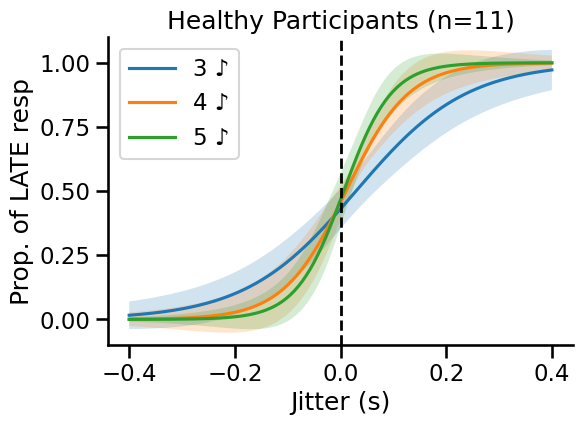

In [9]:
plot_sigmoid_fits(all_pars, group='HC')

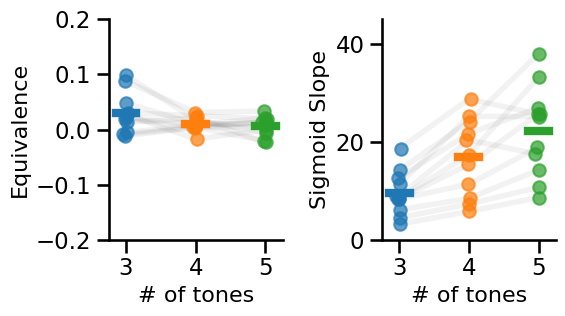

In [10]:
plot_sigmoid_params(all_pars, sub_ids)

### panel B statistics

In [8]:
pars_dict = {'subject' : [],
             'n_tones' : [],
             'equiv' : [],
             'slope' : []}
pars_dict['equiv'] = all_pars[:,:,0].flatten().tolist()
pars_dict['slope'] = all_pars[:,:,1].flatten().tolist()
pars_dict['n_tones'] = np.tile([2,3,4],len(sub_ids)).tolist()
pars_dict['subject'] = np.array([np.repeat(subj, 3) for subj in sub_ids]).flatten().tolist()

pars_df = pd.DataFrame(pars_dict)
pars_df['group'] = np.tile('Healthy', len(pars_df))

In [9]:
# equivalence point
pg.rm_anova(pars_df, dv='equiv', within='n_tones', subject='subject', correction=True, detailed=True)

/opt/miniconda3/envs/prophecy_viz/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,n_tones,0.003317,2,0.001658,3.790369,0.040201,0.058803,0.157386,0.724842,True,inf,1.0
1,Error,0.008750,20,0.000437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
equiv_2 = all_pars[:,0,0]
equiv_3 = all_pars[:,1,0]
equiv_4 = all_pars[:,2,0]

print('mean: '+str([np.mean(x) for x in [equiv_2, equiv_3, equiv_4]]))
print('std: '+str([np.std(x) for x in [equiv_2, equiv_3, equiv_4]]))

mean: [np.float64(0.029160425240212527), np.float64(0.01041796152289391), np.float64(0.006049002443309626)]
std: [np.float64(0.03440833343368475), np.float64(0.012432347702111797), np.float64(0.01660396234437766)]


In [11]:
equiv23 = pg.ttest(equiv_2, equiv_3, paired=True)
equiv23

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.940427,10,two-sided,0.081024,"[-0.0, 0.04]",0.690775,1.189,0.543467


In [12]:
equiv24 = pg.ttest(equiv_2, equiv_4, paired=True)
equiv24

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.170234,10,two-sided,0.055148,"[-0.0, 0.05]",0.815689,1.585,0.684441


In [13]:
equiv34 = pg.ttest(equiv_3, equiv_4, paired=True)
equiv34

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.773171,10,two-sided,0.457308,"[-0.01, 0.02]",0.28401,0.383,0.136836


In [14]:
# sigmoid slope
slope_anova = pg.rm_anova(pars_df, dv='slope', within='n_tones', subject='subject', correction=True)
slope_anova

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,n_tones,2,20,26.396105,0.000002,0.000023,0.351558,0.781569,True,0.720522,0.228777


In [15]:
slope_2 = all_pars[:,0,1]
slope_3 = all_pars[:,1,1]
slope_4 = all_pars[:,2,1]

print('mean: ' + str([np.mean(x) for x in [slope_2, slope_3, slope_4]]))
print('std: ' + str([np.std(x) for x in [slope_2, slope_3, slope_4]]))

mean: [np.float64(9.560860870124905), np.float64(16.89744000251254), np.float64(22.234365915446276)]
std: [np.float64(4.231269561248304), np.float64(7.461290794354747), np.float64(8.70531966394181)]


In [16]:
slope23 = pg.ttest(slope_2, slope_3, paired=True)
slope23

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.012475,10,two-sided,0.00013,"[-10.06, -4.62]",1.153317,229.619,0.930345


In [17]:
slope24 = pg.ttest(slope_2, slope_4, paired=True)
slope24

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.200007,10,two-sided,0.000101,"[-17.23, -8.12]",1.76554,284.056,0.999466


In [18]:
slope34 = pg.ttest(slope_3, slope_4, paired=True)
slope34

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.838247,10,two-sided,0.017601,"[-9.53, -1.15]",0.627659,3.849,0.468682


In [19]:
# Holm-Bonferroni multiple comparisons correction

all_tests = [equiv23, equiv24, equiv34, slope23, slope24, slope34]

pvals = [test['p-val'].values for test in all_tests]
signif, p_corr = pg.multicomp(pvals, alpha = 0.05, method='holm')

for test, s, p in zip(all_tests, signif, p_corr):
    print(test)
    print('Significant: '+str(s))
    print('P-corr '+str(p)+'\n\n')

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  1.940427   10   two-sided  0.081024  [-0.0, 0.04]  0.690775  1.189   

           power  
T-test  0.543467  
Significant: [False]
P-corr [0.16544442]


               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.170234   10   two-sided  0.055148  [-0.0, 0.05]  0.815689  1.585   

           power  
T-test  0.684441  
Significant: [False]
P-corr [0.16544442]


               T  dof alternative     p-val          CI95%  cohen-d   BF10  \
T-test  0.773171   10   two-sided  0.457308  [-0.01, 0.02]  0.28401  0.383   

           power  
T-test  0.136836  
Significant: [False]
P-corr [0.45730792]


               T  dof alternative    p-val            CI95%   cohen-d  \
T-test -6.012475   10   two-sided  0.00013  [-10.06, -4.62]  1.153317   

           BF10     power  
T-test  229.619  0.930345  
Significant: [ True]
P-corr [0.00064965]


               T  dof alternative     p-

## panel C

In [11]:
resdir = "/Users/sydneysmith/Projects/PrOPHEcy/PrOPHEcy/00-data/behav"

subData, sub_ids = load_behav(resdir)
all_pars = compute_sigmoid_fit_params(subData, cost)

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

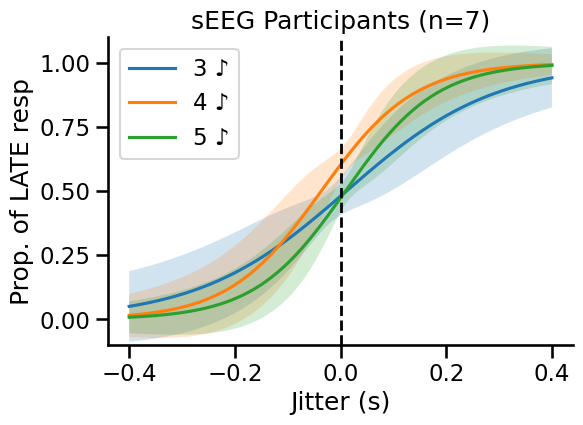

In [12]:
plot_sigmoid_fits(all_pars, group='sEEG')

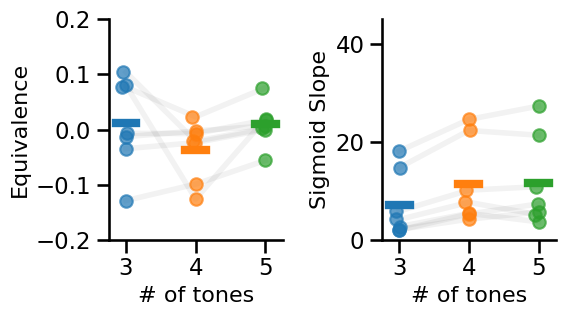

In [13]:
plot_sigmoid_params(all_pars, sub_ids)

### panel C statistics

In [23]:
subjs = [1002, 1005, 1007, 1008, 1009, 1010, 1014]

pars_dict = {'subject' : [],
             'n_tones' : [],
             'equiv' : [],
             'slope' : []}
pars_dict['equiv'] = all_pars[:,:,0].flatten().tolist()
pars_dict['slope'] = all_pars[:,:,1].flatten().tolist()
pars_dict['n_tones'] = np.tile([2,3,4],len(subjs)).tolist()
pars_dict['subject'] = np.array([np.repeat(subj, 3) for subj in subjs]).flatten().tolist()

pars_df = pd.DataFrame(pars_dict)
pars_df['group'] = np.tile('iEEG', len(pars_df))

In [24]:
# equivalence point
pg.rm_anova(pars_df, dv='equiv', within='n_tones', subject='subject', correction=True)

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,n_tones,2,12,2.298676,0.142842,0.169514,0.132578,0.641222,True,1029.624105,1.0


In [25]:
equiv_2 = all_pars[:,0,0]
equiv_3 = all_pars[:,1,0]
equiv_4 = all_pars[:,2,0]

print('mean: '+str([np.mean(x) for x in [equiv_2, equiv_3, equiv_4]]))
print('std: '+str([np.std(x) for x in [equiv_2, equiv_3, equiv_4]]))

mean: [np.float64(0.011116833623326241), np.float64(-0.036580203534916644), np.float64(0.009250326031188314)]
std: [np.float64(0.0757208781562707), np.float64(0.050403728134909606), np.float64(0.03571888590784077)]


In [26]:
# sigmoid slope

pg.rm_anova(pars_df, dv='slope', within='n_tones', subject='subject', correction=True)

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,n_tones,2,12,15.991793,0.000412,0.001634,0.070426,0.756235,True,0.67766,0.378033


In [27]:
slope_2 = all_pars[:,0,1]
slope_3 = all_pars[:,1,1]
slope_4 = all_pars[:,2,1]

print('mean: '+str([np.mean(x) for x in [slope_2, slope_3, slope_4]]))
print('std: '+str([np.std(x) for x in [slope_2, slope_3, slope_4]]))

mean: [np.float64(7.1253487657513475), np.float64(11.3908455260576), np.float64(11.632632186358558)]
std: [np.float64(6.080893601747111), np.float64(7.8484083866359), np.float64(8.43309886259314)]


In [28]:
# post-hoc ttests

equiv23 = pg.ttest(equiv_2, equiv_3, paired=True)
equiv23

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.441918,6,two-sided,0.199415,"[-0.03, 0.13]",0.686547,0.747,0.334181


In [29]:
equiv24 = pg.ttest(equiv_2, equiv_4, paired=True)
equiv24

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.082612,6,two-sided,0.936847,"[-0.05, 0.06]",0.02919,0.354,0.050496


In [30]:
equiv34 = pg.ttest(equiv_3, equiv_4, paired=True)
equiv34

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.644747,6,two-sided,0.038297,"[-0.09, -0.0]",0.971339,2.419,0.576335


In [31]:
slope23 = pg.ttest(slope_2, slope_3, paired=True)
slope23

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.602932,6,two-sided,0.001377,"[-6.13, -2.4]",0.562507,31.758,0.241896


In [32]:
slope24 = pg.ttest(slope_2, slope_4, paired=True)
slope24

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.014883,6,two-sided,0.006999,"[-7.25, -1.76]",0.567616,8.852,0.245403


In [33]:
slope34 = pg.ttest(slope_3, slope_4, paired=True)
slope34

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.319731,6,two-sided,0.760012,"[-2.09, 1.61]",0.02748,0.369,0.050439


In [34]:
# Holm-Bonferroni for multiple comparisons

all_tests = [equiv23, equiv24, equiv34, slope23, slope24, slope34]

pvals = [test['p-val'].values for test in all_tests]
signif, p_corr = pg.multicomp(pvals, alpha = 0.05, method='holm')

for test, s, p in zip(all_tests, signif, p_corr):
    print(test)
    print('Significant: '+str(s))
    print('P-corr '+str(p)+'\n\n')

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.441918    6   two-sided  0.199415  [-0.03, 0.13]  0.686547  0.747   

           power  
T-test  0.334181  
Significant: [False]
P-corr [0.5982446]


               T  dof alternative     p-val          CI95%  cohen-d   BF10  \
T-test  0.082612    6   two-sided  0.936847  [-0.05, 0.06]  0.02919  0.354   

           power  
T-test  0.050496  
Significant: [False]
P-corr [1.]


               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -2.644747    6   two-sided  0.038297  [-0.09, -0.0]  0.971339  2.419   

           power  
T-test  0.576335  
Significant: [False]
P-corr [0.1531863]


               T  dof alternative     p-val          CI95%   cohen-d    BF10  \
T-test -5.602932    6   two-sided  0.001377  [-6.13, -2.4]  0.562507  31.758   

           power  
T-test  0.241896  
Significant: [ True]
P-corr [0.00826288]


               T  dof alternative     p-val       

# panel D

This panel contains sEEG electrode location information, and these data are available upon reasonable request, subject to IRB approval.